In [1]:
#Importing important librarys
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
le = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mBusData = pd.read_csv('/content/drive/MyDrive/datasets/Iot_processed/IoT_Modbus.csv')
mBusData.head()

,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,31-Mar-19,12:36:55,53287,1463,33518,23014,0,normal
1,31-Mar-19,12:36:58,41029,55891,26004,50645,0,normal
2,31-Mar-19,12:36:58,41029,55891,26004,50645,0,normal
3,31-Mar-19,12:37:00,64661,40232,33460,44046,0,normal
4,31-Mar-19,12:37:01,64661,40232,33460,44046,0,normal


In [4]:
mBusData.drop('type', axis = 1, inplace=True)
mBusData.drop(mBusData.iloc[:, 0:2], axis = 1, inplace=True)
mBusData.head()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label
0,53287,1463,33518,23014,0
1,41029,55891,26004,50645,0
2,41029,55891,26004,50645,0
3,64661,40232,33460,44046,0
4,64661,40232,33460,44046,0


In [5]:
# import matplotlib.pyplot as plt
# columns = mBusData.columns
# for col in columns:
#     print("col: ", col)
#     mBusData[col].hist(bins = 100)
#     plt.show()

# **Train Test with Skfold**

In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=3)

x=mBusData[['FC1_Read_Input_Register','FC2_Read_Discrete_Value','FC3_Read_Holding_Register','FC4_Read_Coil']]
y=mBusData['label' ]

In [7]:
# --------------------------KNN -----------------------------------
for train_index, test_index in skf.split(x, y):
    x_train, x_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train) #Training the model
y_pred_knn = knn.predict(x_test)
print(y_pred_knn)# printing predictions

#Accuracy Score

from sklearn.metrics import accuracy_score
knnAccuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy of knn : ",knnAccuracy*100,'%')

#F1 Score

from sklearn.metrics import f1_score
knnf1_scr = f1_score(y_test, y_pred_knn)
print("f1_score of knn : ",knnf1_scr*100,'%')

#AUC Score

from sklearn.metrics import roc_auc_score, confusion_matrix
auc = roc_auc_score (y_test, y_pred_knn)
print('AUC: %.2f' % auc)

[0 0 0 ... 0 0 0]
Accuracy of knn :  87.77403270286081 %
f1_score of knn :  73.35640138408304 %
AUC: 0.83


In [8]:
confusion_matrix(y_test,y_pred_knn)

array([[25468,  2388],
       [ 2001,  6042]])

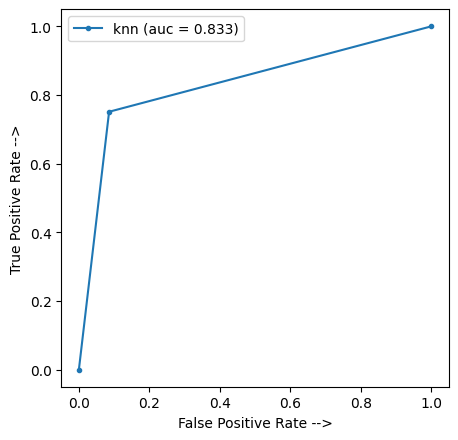

In [9]:
#ROC CURVE:
from sklearn.metrics import roc_curve, auc

knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_pred_knn)
auc_knn = auc(knn_fpr, knn_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(knn_fpr, knn_tpr, marker='.', label='knn (auc = %0.3f)' % auc_knn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [ ]:
!pip install interpret

In [12]:
#Interpretable => LR, DTC, EMB
from interpret.glassbox import (LogisticRegression, ClassificationTree, ExplainableBoostingClassifier)
from interpret import show
from sklearn.metrics import f1_score, accuracy_score
import shap
#Lime => Black Box Models like RF
from interpret.blackbox import LimeTabular
from interpret import show

In [13]:
# %% Explainable Boosting Machine
ebm = ExplainableBoostingClassifier(random_state=2021)
ebm.fit(x_train, y_train) 
print("Training finished.")
y_pred = ebm.predict(x_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
# %% Explain locally
ebm_local = ebm.explain_local(x_test[:100], y_test[:100], name='EBM')
show(ebm_local)
# %% Explain globally
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)
# %%


Training finished.
F1 Score 0.4369225943063289
Accuracy 0.7759547619710856


In [18]:
# %% KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
# %% Apply lime
# Initilize Lime for Tabular data
lime = LimeTabular(predict_fn=knn.predict_proba, 
                   data=x_train, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(x_test[-100:], 
                                y_test[-100:], 
                                name='LIME')
show(lime_local)

F1 Score 0.7283555739264413
Accuracy 0.8166522744366138


F1 Score 0.7283555739264413
Accuracy 0.8166522744366138


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 4)


The KNN predicted: 0


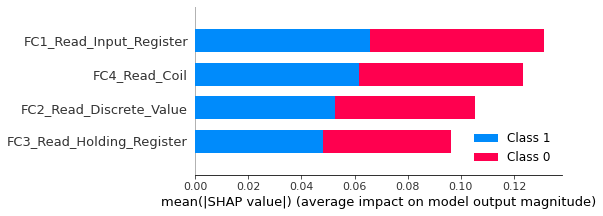

In [17]:
# %% KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
# %% Create SHAP explainer
explainer = shap.KernelExplainer(knn.predict_proba, x_train)
# Calculate shapley values for test data
start_index = 1
end_index = 2
shap_values = explainer.shap_values(x_test[start_index:end_index])
x_test[start_index:end_index]
# %% Investigating the values (classification problem)
# class 0 = contribution to class 1
# class 1 = contribution to class 2
print(shap_values[0].shape)
shap_values
# %% >> Visualize local predictions
shap.initjs()
# Force plot
prediction = knn.predict(x_test[start_index:end_index])[0]
print(f"The KNN predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                x_test[start_index:end_index]) # for values
# %% >> Visualize global features
# Feature summary
shap.summary_plot(shap_values, x_test)

# **Oversampling**

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np
#Seeing the value count before oversampling
unique, count = np.unique(y_train, return_counts = True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique, count)}
print("Before oversampling",y_train_dict_value_count)

sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

# Seeing the value count after oversampling
unique, count = np.unique(y_train_sm, return_counts = True)
y_train_smote_value_count = {k:v for (k,v) in zip(unique, count)}
print("After oversampling",y_train_smote_value_count)

Before oversampling {0: 194999, 1: 56296}
After oversampling {0: 194999, 1: 194999}


In [ ]:
# -------------------------- KNN -----------------------------------
for train_index, test_index in skf.split(x_train_sm, y_train_sm):
    x_train, x_test, y_train, y_test = x_train_sm.iloc[train_index], x_train_sm.iloc[test_index], y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
    
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train) #Training the model
y_pred_knn = knn.predict(x_test)
print(y_pred_knn)# printing predictions


#Accuracy Score

from sklearn.metrics import accuracy_score
knnAccuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy of Knn : ",knnAccuracy*100,'%')

#F1 Score

from sklearn.metrics import f1_score
knnf1_scr = f1_score(y_test, y_pred_knn)
print("f1_score of Knn : ",knnf1_scr*100,'%')

#AUC Score

from sklearn.metrics import roc_auc_score
auc = roc_auc_score (y_test, y_pred_knn)
print('AUC: %.2f' % auc)

[0 0 0 ... 1 1 1]
Accuracy of Knn :  92.30753451352848 %
f1_score of Knn :  92.6926224716474 %
AUC: 0.92


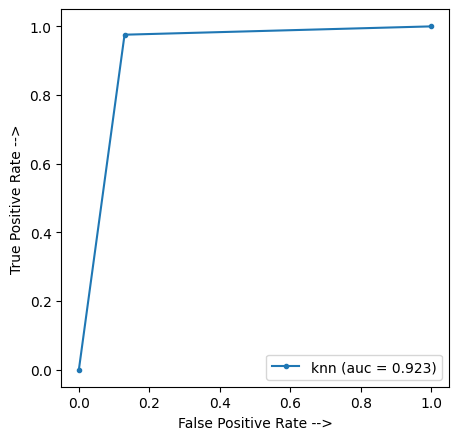

In [ ]:
#ROC CURVE:
from sklearn.metrics import roc_curve, auc

knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_pred_knn)
auc_knn = auc(knn_fpr, knn_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(knn_fpr, knn_tpr, marker='.', label='knn (auc = %0.3f)' % auc_knn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()